In [1]:
%matplotlib inline

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/dan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dan/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# We split the train and dev datasets roughly 75/25
data = pd.read_json("train.json")
train_data = data[:3500]["request_text"]
train_labels = data[:3500]["requester_received_pizza"]
dev_data = data[3500:]["request_text"]
dev_labels = data[3500:]["requester_received_pizza"]
data.head(3)

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,0,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,...,False,[],0,1,0,1,None,nickylvst,1317852607,1317849007
1,N/A,2,5,0,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1332652424,1332648824
2,N/A,0,3,0,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.0000,...,False,[],0,3,0,3,None,jacquibatman7,1319650094,1319646494


## Collecting the entire JSON post including metadata in a dataframe. Many of the values are numeric or categoric. They may have value for logistic regression.

In [3]:
train_data_json = data[:3500]
dev_data_json = data[3500:]

## Data Column Names

In [4]:
list(train_data_json)

[u'giver_username_if_known',
 u'number_of_downvotes_of_request_at_retrieval',
 u'number_of_upvotes_of_request_at_retrieval',
 u'post_was_edited',
 u'request_id',
 u'request_number_of_comments_at_retrieval',
 u'request_text',
 u'request_text_edit_aware',
 u'request_title',
 u'requester_account_age_in_days_at_request',
 u'requester_account_age_in_days_at_retrieval',
 u'requester_days_since_first_post_on_raop_at_request',
 u'requester_days_since_first_post_on_raop_at_retrieval',
 u'requester_number_of_comments_at_request',
 u'requester_number_of_comments_at_retrieval',
 u'requester_number_of_comments_in_raop_at_request',
 u'requester_number_of_comments_in_raop_at_retrieval',
 u'requester_number_of_posts_at_request',
 u'requester_number_of_posts_at_retrieval',
 u'requester_number_of_posts_on_raop_at_request',
 u'requester_number_of_posts_on_raop_at_retrieval',
 u'requester_number_of_subreddits_at_request',
 u'requester_received_pizza',
 u'requester_subreddits_at_request',
 u'requester_upvo

## We can assess the metadata for inclusion in a regression model and clean where needed. We will do a lot of plot histograms and getting a statistical summary with the describe() function so we aggregate those functions into one.

In [4]:
import math

def describe_n_hist(df,bins=-1):
    if bins == -1:
        bins = int(math.ceil(df.max()))        
    df.hist(bins=bins)
    plt.title("Histogram of "+df.name)
    plt.xlabel(df._name)
    plt.ylabel("Frequency")
    plt.show()
    
    print(df.describe())

## "giver_username_if_known": Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise). 

### This is a string value that is not a candidate for regression.

## "number_of_downvotes_of_request_at_retrieval": Number of downvotes at the time the request was collected.

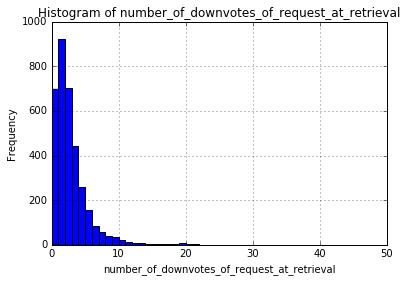

count    3500.000000
mean        2.432571
std         3.056442
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        47.000000
Name: number_of_downvotes_of_request_at_retrieval, dtype: float64


In [95]:
describe_n_hist(train_data_json['number_of_downvotes_of_request_at_retrieval'])

## "number_of_upvotes_of_request_at_retrieval": Number of upvotes at the time the request was collected.

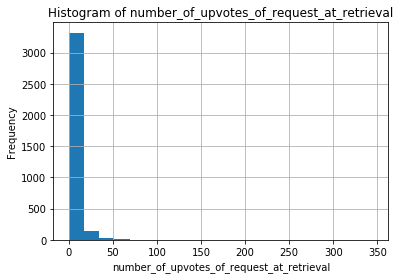

count    3500.000000
mean        6.256000
std        11.249675
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       345.000000
Name: number_of_upvotes_of_request_at_retrieval, dtype: float64


In [62]:
describe_n_hist(train_data_json['number_of_upvotes_of_request_at_retrieval'],20)

## "post_was_edited": Boolean indicating whether this post was edited (from Reddit).

In [7]:
train_data_json['post_was_edited'].describe()

count    3.500000e+03
mean     1.005614e+08
std      3.557997e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.380374e+09
Name: post_was_edited, dtype: float64

### "post_was_edited" should be a boolean (0 or 1) but miscoded values are present. Cleaning is required.

#### By inspection, it appears that edited posts are typically annotated with the literal string "edit". We can correct those.

In [5]:
bad_value_indices = []
for index,edit in enumerate(train_data_json['post_was_edited']):
    if edit == 0 or edit == 1:
        continue
    else:
        bad_value_indices.append(index)
        if "edit" in train_data_json['request_text'][index]:
            train_data_json['post_was_edited'][index] = 1
        else:
            train_data_json['post_was_edited'][index] = 0

/Users/dan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/dan/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/dan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
len(bad_value_indices)

259

### "post_was_edited" had 259 values miscoded to large integers but those are now corrected with caveat that our method for checking for edits could present false positives if "edit" appears in the original text.

In [8]:
train_data_json['post_was_edited'][bad_value_indices].head(10)

6      0
19     0
25     1
31     0
50     0
54     0
77     0
80     0
86     1
104    0
Name: post_was_edited, dtype: int64

In [9]:
train_data_json['post_was_edited'].describe()

count    3500.000000
mean        0.095429
std         0.293848
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: post_was_edited, dtype: float64

In [10]:
train_data_json['post_was_edited'].value_counts()

0    3166
1     334
Name: post_was_edited, dtype: int64

In [10]:
train_data_json['post_was_edited'].value_counts()[1]/float(len(train_data_json['post_was_edited']))

0.09542857142857143

### About 9.5% of the posts are edited.

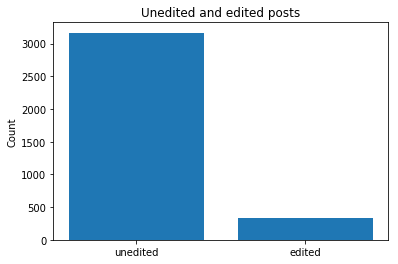

In [11]:
edit = train_data_json['post_was_edited'].value_counts()
plt.bar([0,1], edit, align='center')
plt.xticks([0,1], ["unedited","edited"])
plt.ylabel('Count')
plt.title('Unedited and edited posts')
 
plt.show()

### We are adding "number_of_words_in_post" as a feature

/Users/dan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


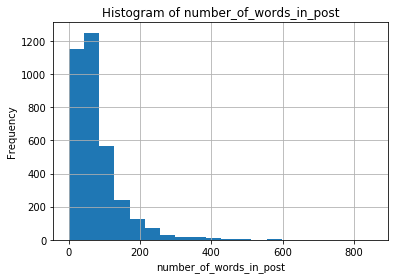

count    3500.000000
mean       78.094571
std        73.007565
min         0.000000
25%        35.000000
50%        59.000000
75%        97.250000
max       854.000000
Name: number_of_words_in_post, dtype: float64


In [7]:
post_lengths = []
for post in train_data_json['request_text']:
    post_lengths.append(len(post.split()))
train_data_json['number_of_words_in_post'] = pd.DataFrame(np.array(post_lengths))
describe_n_hist(train_data_json['number_of_words_in_post'],20)

### We are adding "number_of_words_in_title" as a feature

/Users/dan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


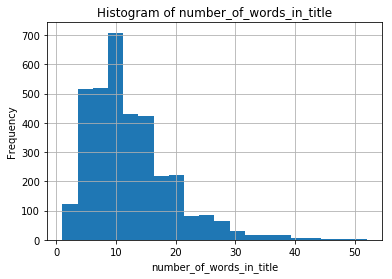

count    3500.000000
mean       12.375429
std         6.984994
min         1.000000
25%         7.000000
50%        11.000000
75%        16.000000
max        52.000000
Name: number_of_words_in_title, dtype: float64


In [8]:
title_lengths = []
for title in train_data_json['request_title']:
    title_lengths.append(len(title.split()))
train_data_json['number_of_words_in_title'] = pd.DataFrame(np.array(title_lengths))
describe_n_hist(train_data_json['number_of_words_in_title'],20)

### "requester_number_of_comments_at_retrieval": Total number of comments on Reddit by requester at time of retrieval.

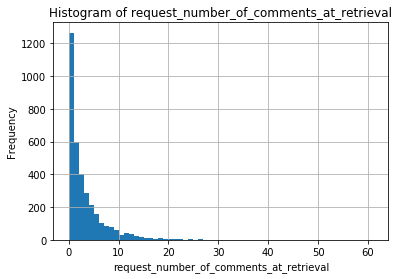

count    3500.000000
mean        2.914286
std         4.711217
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        61.000000
Name: request_number_of_comments_at_retrieval, dtype: float64


In [14]:
describe_n_hist(train_data_json['request_number_of_comments_at_retrieval'])

### "requester_user_flair": Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83).

In [13]:
train_data_json['requester_user_flair'].describe()

count        863
unique         2
top       shroom
freq         810
Name: requester_user_flair, dtype: object

#### The "requester_user_flair" column has values {"None", "shroom", "PIF"}. According to the describe() function, "shroom" appears to be the most frequently occuring value which doesn't match expectations. "None" is interpreted as the object reference None instead of the string we desire. We recode the None values as "None".

In [9]:
new_requester_user_flair = []
for value in train_data_json['requester_user_flair']:
    if value == None:
        new_requester_user_flair.append("None")
    else:
        new_requester_user_flair.append(value)

#new_requester_user_flair
train_data_json['requester_user_flair'] = pd.DataFrame(np.array(new_requester_user_flair))
train_data_json['requester_user_flair'].describe()

/Users/dan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


count     3500
unique       3
top       None
freq      2637
Name: requester_user_flair, dtype: object

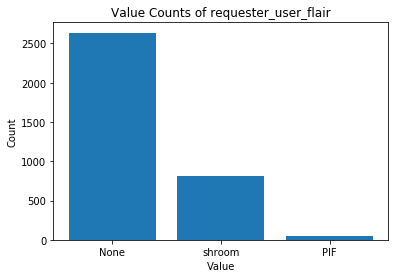

In [10]:
keys = list(train_data_json['requester_user_flair'].value_counts().keys())
key_pos = np.arange(len(keys))
values = list(train_data_json['requester_user_flair'].value_counts().values)

plt.bar(key_pos,values, align='center')
plt.xticks(key_pos,keys)
plt.title("Value Counts of requester_user_flair")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

In [11]:
import time
day_of_week = []
days = {"Sunday":1,"Monday":2,"Tuesday":3,"Wednesday":4,"Thursday":5,"Friday":6,"Saturday":7}
for timestamp in train_data_json['unix_timestamp_of_request']:
    day_of_week.append(days[time.strftime('%A', time.localtime(timestamp))])
train_data_json['day_of_week'] = pd.DataFrame(np.array(day_of_week))

/Users/dan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


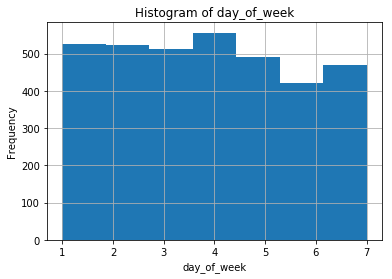

count    3500.000000
mean        3.888571
std         1.978199
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         7.000000
Name: day_of_week, dtype: float64


In [12]:
describe_n_hist(train_data_json['day_of_week'],7)

### Wednesday is the most likely day to request. Thursday is the least likely day to request.

In [13]:
import time
month = []
for timestamp in train_data_json['unix_timestamp_of_request']:
    month.append(int(time.strftime('%-m', time.localtime(timestamp))))
train_data_json['month'] = pd.DataFrame(np.array(month))

/Users/dan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


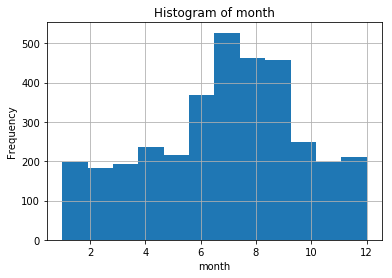

count    3500.000000
mean        6.878571
std         2.979850
min         1.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        12.000000
Name: month, dtype: float64


In [15]:
describe_n_hist(train_data_json['month'])

### July is the month with the most requests

# There are correlations in the JSON metadata that may justify looking at an ensemble that includes Logistic Regression.

In [16]:
corr_matrix = train_data_json.corr()
corr_matrix['requester_received_pizza'].sort_values(ascending=False)

requester_received_pizza                                1.000000
requester_number_of_posts_on_raop_at_retrieval          0.464928
request_number_of_comments_at_retrieval                 0.290732
requester_number_of_comments_in_raop_at_retrieval       0.273771
requester_number_of_posts_on_raop_at_request            0.148392
requester_number_of_comments_in_raop_at_request         0.133604
post_was_edited                                         0.132316
requester_days_since_first_post_on_raop_at_retrieval    0.130892
requester_account_age_in_days_at_retrieval              0.129714
number_of_words_in_post                                 0.118011
requester_days_since_first_post_on_raop_at_request      0.107133
requester_number_of_comments_at_retrieval               0.106592
number_of_upvotes_of_request_at_retrieval               0.095123
requester_upvotes_minus_downvotes_at_retrieval          0.077164
requester_account_age_in_days_at_request                0.051151
requester_number_of_posts

In [25]:
y = train_data_json['requester_received_pizza']

In [26]:
X = train_data_json[['requester_number_of_posts_on_raop_at_retrieval']]
lr1 = LogisticRegression().fit(X,y)
lr1.predict(dev_data_json[['requester_number_of_posts_on_raop_at_retrieval']])
lr1.score(X,y)

0.8314285714285714

In [27]:
X2 = train_data_json[['requester_number_of_posts_on_raop_at_retrieval', \
                      'request_number_of_comments_at_retrieval']]
lr2 = LogisticRegression().fit(X2,y)
lr2.predict(dev_data_json[['requester_number_of_posts_on_raop_at_retrieval', \
                           'request_number_of_comments_at_retrieval']])
lr2.score(X2,y)

0.8362857142857143

In [28]:
X3 = train_data_json[['requester_number_of_posts_on_raop_at_retrieval', \
                      'request_number_of_comments_at_retrieval', \
                      'requester_number_of_comments_in_raop_at_retrieval']]
lr3 = LogisticRegression().fit(X3,y)
lr3.predict(dev_data_json[['requester_number_of_posts_on_raop_at_retrieval', \
                           'request_number_of_comments_at_retrieval', \
                           'requester_number_of_comments_in_raop_at_retrieval']])
lr3.score(X3,y)

0.836

In [29]:
X4 = train_data_json[['requester_number_of_posts_on_raop_at_retrieval', \
                      'request_number_of_comments_at_retrieval', \
                      'requester_number_of_comments_in_raop_at_retrieval',
                      'requester_number_of_posts_on_raop_at_request']]
lr4 = LogisticRegression().fit(X4,y)
lr4.predict(dev_data_json[['requester_number_of_posts_on_raop_at_retrieval',\
                           'request_number_of_comments_at_retrieval', \
                           'requester_number_of_comments_in_raop_at_retrieval',
                           'requester_number_of_posts_on_raop_at_request']])
lr4.score(X4,y)

0.8388571428571429